In [1]:
import os
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
root_dir = '/kaggle/input/hms-harmful-brain-activity-classification'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

# set path variables
train_eegs = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs'
train_spectrograms = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms'


In [3]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


Test Data Shape: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


Sample Submission Shape: (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


### Takeaways
* There are three csv files: train, test, ss
* There are two folders for training, train_eegs and train_spectrograms
* The training csv has 106K rows and 15 columns
    * There are 17,089 unique eeg_ids, which means there are an average of 6.29 sub_eeg's per id, but some have over 700 (743 max) instances and some have 1.
    * There are 11,138 unique spectrogram ids, which means there are about 9.5 per spectrogram_id, one has 1022 of them, where many have just 1 instance
    * There are 17.3k files in the train_eegs folder (from hover over folder - need to verify)
        * why not a perfect match with unique eeg_ids?
    * There are 11.1K files in the train_spectrograms folder


In [4]:
# count the number of parquet files in the folders
import glob
train_eeg_files = glob.glob(train_eegs + '/*.parquet')
len(train_eeg_files)

17300

In [5]:
train_spectrogram_files = glob.glob(train_spectrograms + '/*.parquet')
len(train_spectrogram_files)

11138

* so the number of spectrogram file match (11138 = 11138)
* but the number of eeg files dont (17300 != 17089)
    * investigate why.  Is this a problem?
    * they are files without paired spectrograms, so just ignore them.  See [discussion here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467058)


## Look at an EEG parquet file

In [6]:
train_eeg_files[6]

'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2917825580.parquet'

In [29]:
eeg_file = train_eeg_files[2]
# get first EEG file
#eeg_file = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1628180742.parquet'
print(f'EEG File: {eeg_file}')
eeg_df = pd.read_parquet(eeg_file)
print(f'EEG shape: {eeg_df.shape}')
eeg_df.head()

EEG File: /kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3959808174.parquet
EEG shape: (10000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-31.129999,-34.029999,-85.910004,-54.650002,-44.220001,-100.620003,-56.389999,-61.439999,21.059999,71.949997,-12.970000,-45.720001,-23.809999,49.259998,22.490000,-10.06,2.11,6.71,0.07,-1425.859985
1,-28.040001,-29.059999,-82.050003,-52.439999,-39.549999,-95.570000,-51.709999,-58.930000,19.700001,72.739998,-16.129999,-43.189999,-21.070000,50.740002,23.580000,-8.84,3.68,7.51,-0.01,-106.720001
2,-23.520000,-22.530001,-75.129997,-45.259998,-31.860001,-86.300003,-43.290001,-52.860001,27.030001,80.989998,-8.420000,-41.599998,-16.139999,55.840000,27.469999,-5.72,6.38,10.84,3.35,1278.859985
3,-19.660000,-22.469999,-76.250000,-44.910000,-32.730000,-85.339996,-42.919998,-53.700001,34.669998,84.239998,-4.950000,-38.779999,-16.180000,54.549999,25.389999,-9.88,2.28,7.68,1.42,-902.020020
4,-18.559999,-23.350000,-77.860001,-47.830002,-33.290001,-84.989998,-43.619999,-55.680000,28.430000,79.099998,-11.290000,-41.840000,-20.230000,48.430000,21.049999,-16.51,-2.58,3.11,-2.02,-940.299988


In [30]:
eid = int(eeg_file.split('/')[-1].split('.')[0])
print(eid)
train.loc[train.eeg_id == eid]

3959808174


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
40810,3959808174,0,0.0,784750288,30,1139.0,1269517314,29441,LPD,0,1,0,0,0,0


* So far, all eeg shapes (spot check on 5-10) have been 12000 x 20
* The first in the train set: 1628180742, has 18000 rows, last label offset says 40 sec
* I assume this is time based, but what is the time?  How much time for each file?  
    * Each is 50 sec long according to the Description
    * not sure this lines up, as not all seem to add up to 18000
* make some sort of map, then saved it as a file/df, take an fft, look at different projections


In [31]:
# look at just one eeg_id in train
train1 = train[train.eeg_id == 1628180742]
train1

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0


### Make an EEG Plot
* From a single parquet file

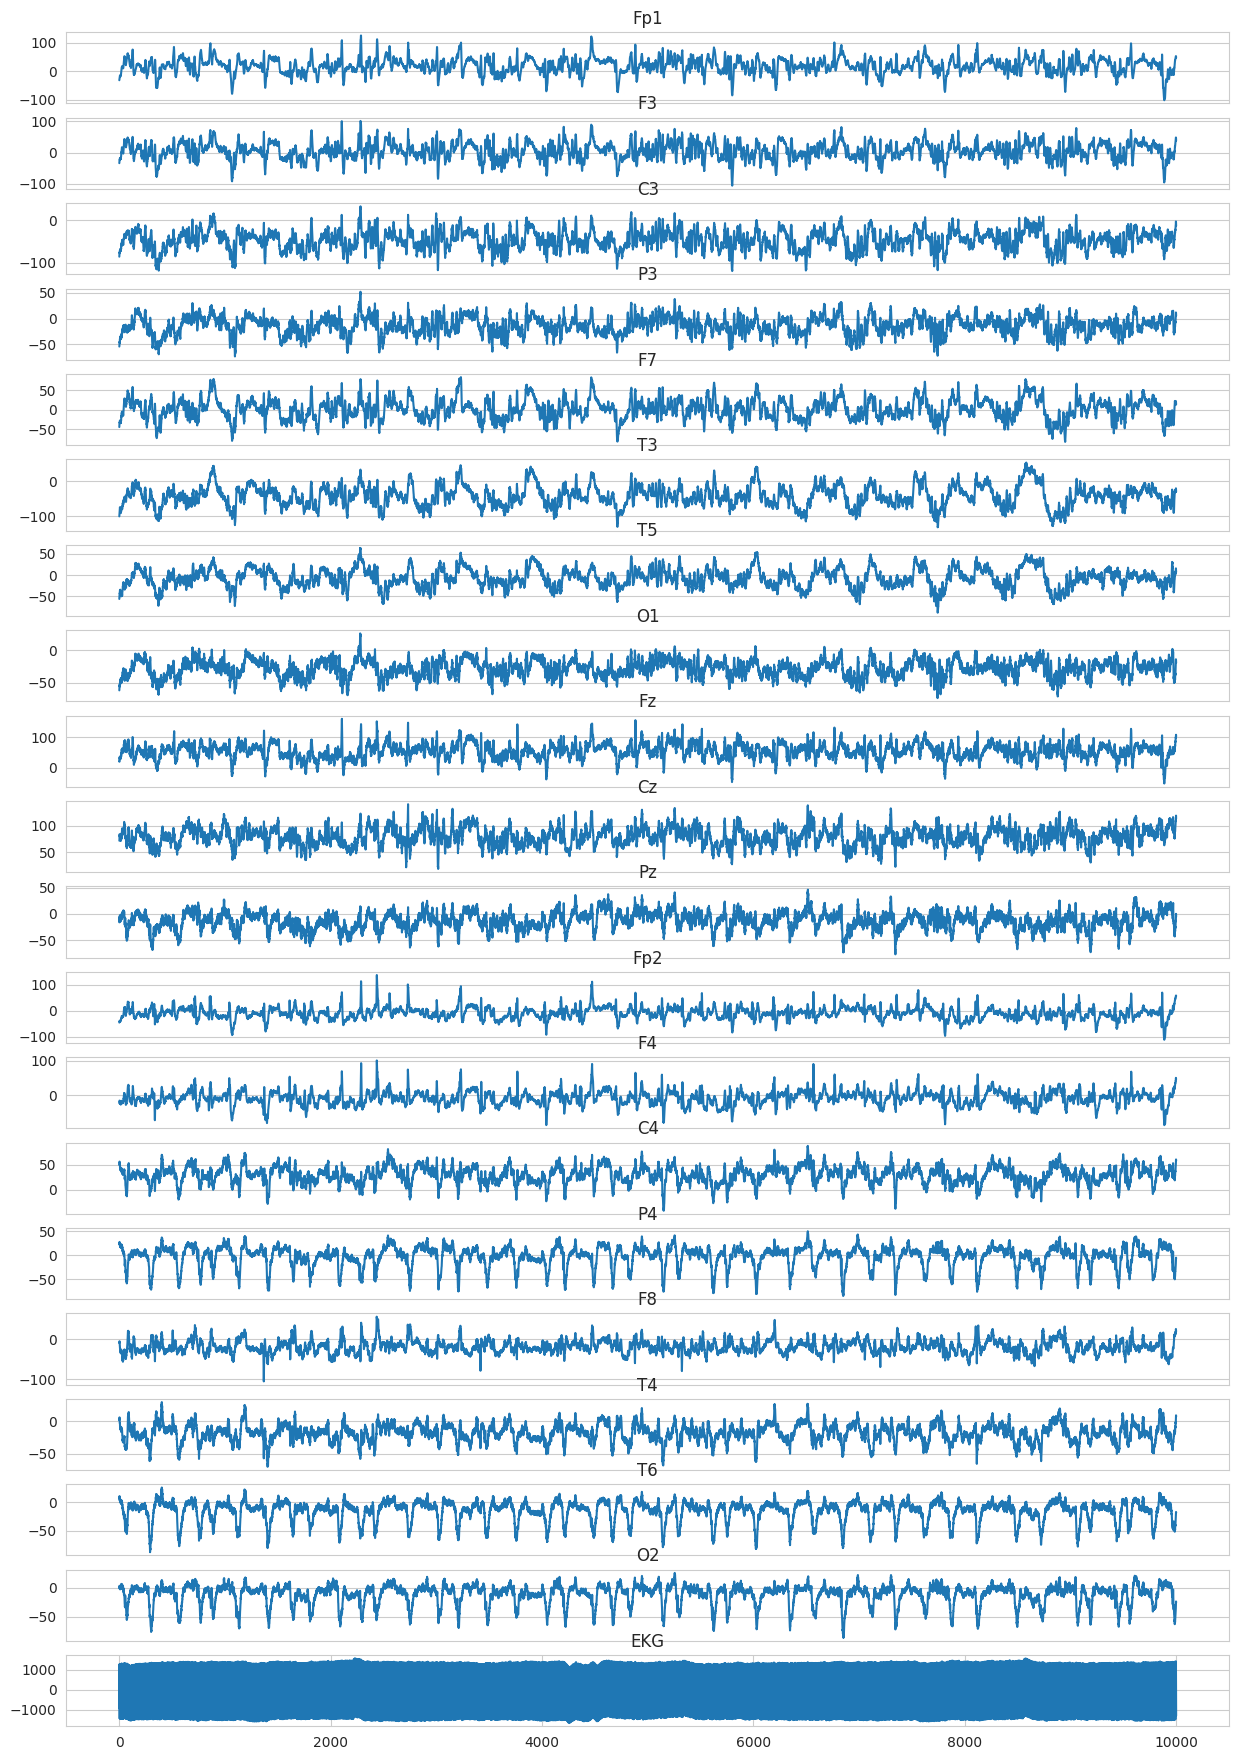

In [50]:
num_rows = len(eeg_df.columns)
plt.figure(figsize=(15,22))#,tight_layout=True)

for i,col in enumerate(eeg_df.columns):
    plt.subplot(num_rows,1,i+1)
    plt.plot(eeg_df[col])
    if i < num_rows-1:
        plt.xticks([])
    plt.title(f'{col}')

## Look at a spectrogram file

In [10]:
spect_file = train_spectrogram_files[0]
spect_df = pd.read_parquet(spect_file)
print(f'Spectrogram file shape: {spect_df.shape}')
spect_df.head()

Spectrogram file shape: (408, 401)


,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,LL_2.54,LL_2.73,LL_2.93,LL_3.13,LL_3.32,LL_3.52,LL_3.71,LL_3.91,LL_4.1,LL_4.3,LL_4.49,LL_4.69,LL_4.88,LL_5.08,...,RP_15.23,RP_15.43,RP_15.63,RP_15.82,RP_16.02,RP_16.21,RP_16.41,RP_16.6,RP_16.8,RP_16.99,RP_17.19,RP_17.38,RP_17.58,RP_17.77,RP_17.97,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,42.840000,64.959999,74.739998,68.199997,65.529999,49.970001,26.570000,10.670000,8.13,7.17,7.54,5.78,4.51,2.95,2.54,1.15,1.07,0.76,0.55,0.64,0.67,0.66,0.62,0.43,...,0.14,0.14,0.10,0.11,0.13,0.13,0.11,0.10,0.06,0.06,0.05,0.03,0.04,0.06,0.06,0.04,0.03,0.02,0.04,0.04,0.03,0.02,0.02,0.03,0.03
1,3,71.879997,76.199997,92.510002,59.869999,52.480000,36.360001,22.139999,11.690000,7.05,8.28,6.30,6.76,4.53,4.49,2.83,2.90,3.01,2.26,1.97,1.19,0.77,0.53,0.48,0.26,...,0.20,0.28,0.20,0.30,0.24,0.19,0.23,0.14,0.14,0.12,0.09,0.06,0.09,0.07,0.05,0.05,0.04,0.03,0.03,0.04,0.04,0.03,0.03,0.02,0.02
2,5,71.070000,69.919998,85.910004,55.189999,27.730000,14.450000,6.990000,4.560000,4.34,6.78,4.09,4.22,4.22,3.19,3.00,2.67,2.93,2.24,1.59,1.74,0.91,0.59,0.69,0.62,...,0.10,0.22,0.24,0.24,0.21,0.12,0.09,0.13,0.13,0.10,0.07,0.06,0.02,0.03,0.04,0.06,0.06,0.07,0.04,0.04,0.02,0.03,0.04,0.02,0.03
3,7,59.910000,92.000000,95.970001,100.220001,72.419998,38.990002,19.840000,13.800000,10.47,7.21,5.50,3.78,2.48,2.61,1.98,1.40,1.08,0.85,0.82,0.75,0.81,0.73,0.54,0.51,...,0.07,0.13,0.11,0.12,0.11,0.09,0.09,0.09,0.09,0.08,0.05,0.04,0.04,0.04,0.05,0.06,0.06,0.06,0.06,0.04,0.01,0.02,0.02,0.02,0.02
4,9,31.120001,52.810001,45.450001,45.720001,37.919998,23.990000,20.049999,19.530001,10.60,11.19,7.68,5.52,4.16,3.39,3.42,2.98,2.06,1.57,1.46,1.10,1.18,0.63,0.55,0.43,...,0.11,0.12,0.11,0.09,0.08,0.08,0.09,0.10,0.08,0.10,0.08,0.09,0.06,0.08,0.05,0.04,0.03,0.04,0.04,0.03,0.03,0.01,0.01,0.01,0.02


* First file is 408x401
* Next is 300x401
* Third is 340x401
* Seems perhaps all are 401 columns but different number of rows...
    * rows are time.



### To try:
* train two models, one on spectrograms and one on eegs
* convert spectograms to images and train with neural net